In [1]:
import argparse
import os
import pathlib
import pandas as pd
import torch
import torch.nn.parallel
import torch.optim
import torch.utils.data
import yaml
from torch.utils.tensorboard import SummaryWriter
from dataset.msd import get_datasets
from model import MSNet 
from utils import reload_ckpt_bis, save_args, generate_segmentations_metrics
from logger import msnetLogger
from datetime import datetime

/raid/temuuzhin/anaconda3/envs/env39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/raid/temuuzhin/anaconda3/envs/env39/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/raid/temuuzhin/anaconda3/envs/env39/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


2023-06-11 22:23:19,758 - Created a temporary directory at /tmp/tmp9wifqbnc
2023-06-11 22:23:19,760 - Writing /tmp/tmp9wifqbnc/_remote_module_non_scriptable.py


In [2]:
torch.cuda.set_device(7)

In [3]:
device = torch.device("cuda")

## init model

In [4]:
with open("configs/msnet_base.yaml", 'r') as f:
    yaml_cfg = yaml.load(f, Loader=yaml.FullLoader)

model = MSNet(num_classes=3,
                    embed_dim=yaml_cfg.get("MODEL").get("SWIN").get("EMBED_DIM"),
                    win_size=yaml_cfg.get("MODEL").get("SWIN").get("WINDOW_SIZE")).cuda()
model.load_from(yaml_cfg.get("MODEL").get("PRETRAIN_CKPT"))
model = model.cuda()

MSNetSwinTransformer3D expand initial----depths:[2, 2, 2, 1];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:3;embed_dims:96;window:(7, 7, 7)


/raid/temuuzhin/anaconda3/envs/env39/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1664747343353/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---
pretrained_path:./pretrained_ckpt/swin_tiny_patch4_window7_224_22k.pth
---start load pretrained modle of swin encoder---
delete:patch_embed.proj.weight;shape pretrain:torch.Size([21841]);shape model:torch.Size([96, 4, 4, 4, 4])
delete:layers.0.blocks.0.attn.relative_position_bias_table;shape pretrain:torch.Size([21841]);shape model:torch.Size([2197, 3])
delete:layers.0.blocks.0.attn.relative_position_index;shape pretrain:torch.Size([21841]);shape model:torch.Size([343, 343])
delete:layers.0.blocks.1.attn.relative_position_bias_table;shape pretrain:torch.Size([21841]);shape model:torch.Size([2197, 3])
delete:layers.0.blocks.1.attn.relative_position_index;shape pretrain:torch.Size([21841]);shape model:torch.Size([343, 343])
delete:layers.1.blocks.0.attn.relative_position_bias_table;shape pretrain:torch.Size([21841]);shape model:torch.Size([2197, 6])
delete:layers.1.blocks.0.attn.relative_position_index;shape pretrain:torch.Size([21841]);shape model:torch

## get dataloader


In [5]:
test_dataset = get_datasets(on="test")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, num_workers=2)


## load trained model from .pth.tar 


In [6]:
# checkpoint = pathlib.Path(f"./train_results/model3_200/model_best.pth.tar") 
checkpoint = pathlib.Path(f"./train_results/model3_200/model_best.pth.tar") 
reload_ckpt_bis(f'{checkpoint}', model, device)

=> loading checkpoint train_results/model3_200/model_best.pth.tar


183

## generate_segmentations_metrics() for one example

In [7]:
from utils import *

In [8]:
metrics_list = []
model.eval()

MSNet(
  (swin_unet): MSNetSwinTransformer3D(
    (patch_embed): PatchEmbed3D(
      (proj): Conv3d(4, 96, kernel_size=(4, 4, 4), stride=(4, 4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock3D(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention3D(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_featu

### get one item from Dataloader

In [9]:
it = iter(test_loader)

rerun to iterate

In [20]:
val_data = next(it) 

In [21]:
val_data["id"][0]

tensor(162)

In [22]:
id, image, label = (val_data["id"][0], val_data["image"][0], val_data["label"][0])
print(image.shape, label.shape)
patient_id = val_data["id"][0]
print(f"Validating case {patient_id}")
ref_path = val_data["seg_path"][0]
crops_idx = val_data["crop_indexes"]

ref_seg_img = sitk.ReadImage(ref_path)
ref_seg = sitk.GetArrayFromImage(ref_seg_img)

val_inputs, val_labels = (
    val_data["image"].cuda(),
    val_data["label"].cuda(),
)

with torch.no_grad():
    val_outputs = inference(val_inputs, model)
    val_outputs_processed = [post_pred(i) for i in decollate_batch(val_outputs)]

segs = torch.zeros((1, 3, ref_seg.shape[0], ref_seg.shape[1], ref_seg.shape[2]))
segs[0, :, slice(*crops_idx[0]), slice(*crops_idx[1]), slice(*crops_idx[2])] = val_outputs_processed[0]
segs = segs[0].numpy() > 0

et = segs[0]
net = np.logical_and(segs[1], np.logical_not(et))
ed = np.logical_and(segs[2], np.logical_not(segs[1]))

labelmap = np.zeros(segs[0].shape)
labelmap[et] = 3
labelmap[net] = 2
labelmap[ed] = 1
labelmap = sitk.GetImageFromArray(labelmap)

refmap_et, refmap_tc, refmap_wt = [np.zeros_like(ref_seg) for i in range(3)]
refmap_et = ref_seg == 3
refmap_tc = np.logical_or(refmap_et, ref_seg == 2)
refmap_wt = np.logical_or(refmap_tc, ref_seg == 1)
refmap = np.stack([refmap_et, refmap_tc, refmap_wt])


patient_metric_list, avg_hd, avg_dice = calculate_metrics(segs, refmap, patient_id)
metrics_list.append(patient_metric_list)
labelmap.CopyInformation(ref_seg_img)

print(f"Writing test_results/ipynb_test/BRATS_{'{:03d}'.format(patient_id)}.nii.gz")
sitk.WriteImage(labelmap, f"test_results/ipynb_test/BRATS_{'{:03d}'.format(patient_id)}.nii.gz")


torch.Size([4, 137, 172, 140]) torch.Size([3, 137, 172, 140])
Validating case 162
{   'dice': 0.8254837187352525,
    'haussdorf': 2.23606797749979,
    'label': 'ET',
    'patient_id': tensor(162),
    'sens': 0.8676587301587302,
    'spec': 0.9997349157651112,
    'ssim': 0.9965736799095714}
{   'dice': 0.7541469567959634,
    'haussdorf': 3.1622776601683795,
    'label': 'TC',
    'patient_id': tensor(162),
    'sens': 0.8927131551440943,
    'spec': 0.9992866762703815,
    'ssim': 0.9950990259769276}
{   'dice': 0.9240825955802395,
    'haussdorf': 3.0,
    'label': 'WT',
    'patient_id': tensor(162),
    'sens': 0.9428209660636604,
    'spec': 0.9991189201278945,
    'ssim': 0.991988343922073}
Writing test_results/ipynb_test/BRATS_162.nii.gz


## compare output with GT

In [23]:
def load_nii(path_folder):
        return sitk.GetArrayFromImage(sitk.ReadImage(str(path_folder)))

In [24]:
mine = load_nii(f"/raid/temuuzhin/src/togit/msnet/test_results/model3_200/output/BRATS_{'{:03d}'.format(patient_id)}.nii.gz")
vtunet = load_nii(f"/raid/temuuzhin/src/togit/msnet/test_results/vtunet3_200/output/BRATS_{'{:03d}'.format(patient_id)}.nii.gz")
real = load_nii(f"/raid/temuuzhin/src/DATA/Task01_BrainTumour/labelsTr/BRATS_{'{:03d}'.format(patient_id)}.nii.gz")
origim = load_nii(f"/raid/temuuzhin/src/DATA/Task01_BrainTumour/imagesTr/BRATS_{'{:03d}'.format(patient_id)}.nii.gz")

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

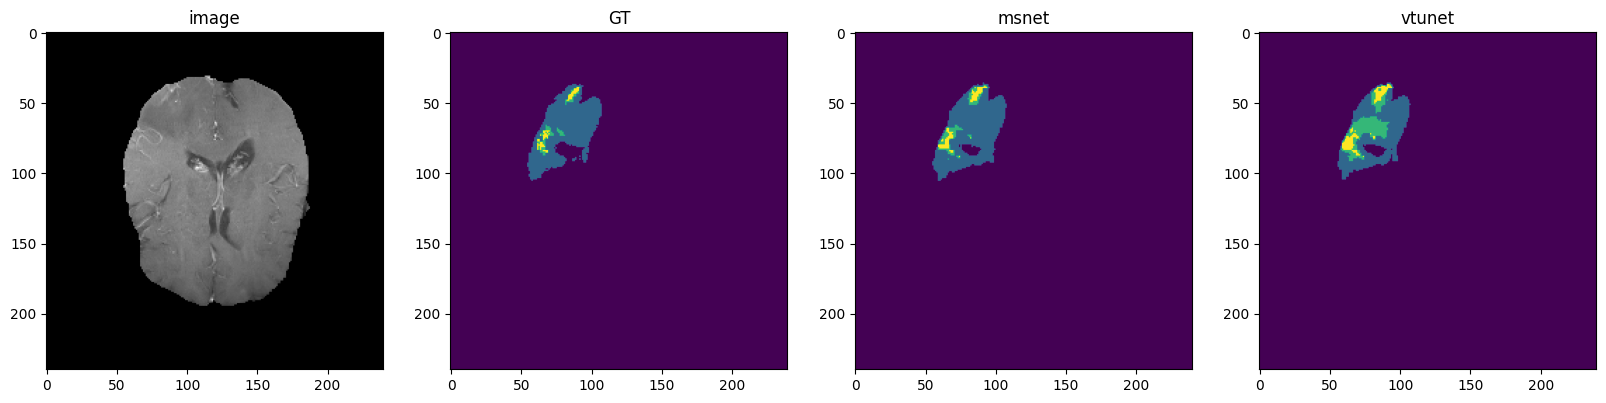

In [27]:
plt.figure("check", (20, 10))

dim =  74  # dimension slice number (0,155)
channel = 2   # channel number of mpMRI (0,4)

plt.subplot(2, 4, 1)
plt.title("image")
plt.imshow(origim[channel, dim, :, :], cmap="gray") 

plt.subplot(2, 4, 2)
plt.title("GT")
plt.imshow(real[dim, :, :])

plt.subplot(2, 4, 3)
plt.title("msnet")
plt.imshow(mine[dim, :, :])

plt.subplot(2, 4, 4)
plt.title("vtunet")
plt.imshow(vtunet[dim, :, :])
plt.show()

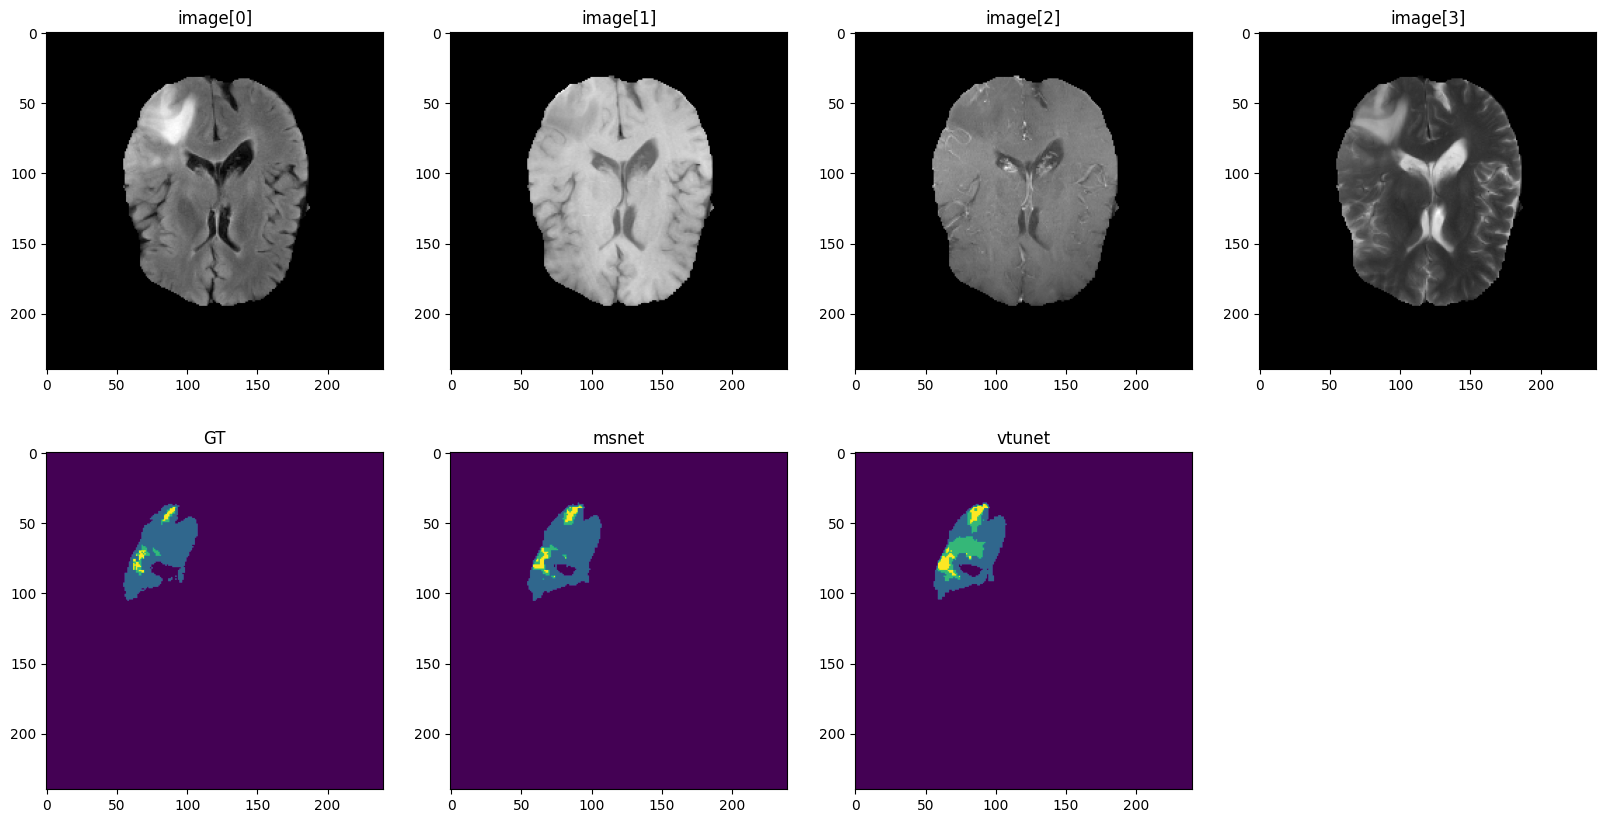

In [28]:
plt.figure("checkexp", (20, 10))

dim = 74   # dimension slice number (0,155)

plt.subplot(2, 4, 1)
plt.title("image[0]")
plt.imshow(origim[0, dim, :, :], cmap="gray") 
plt.subplot(2, 4, 2)
plt.title("image[1]")
plt.imshow(origim[1, dim, :, :], cmap="gray") 
plt.subplot(2, 4, 3)
plt.title("image[2]")
plt.imshow(origim[2, dim, :, :], cmap="gray") 
plt.subplot(2, 4, 4)
plt.title("image[3]")
plt.imshow(origim[3, dim, :, :], cmap="gray") 

plt.subplot(2, 4, 5)
plt.title("GT")
plt.imshow(real[dim, :, :])

plt.subplot(2, 4, 6)
plt.title("msnet")
plt.imshow(mine[dim, :, :])

plt.subplot(2, 4, 7)
plt.title("vtunet")
plt.imshow(vtunet[dim, :, :])

plt.show()